#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [65]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [66]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [67]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [68]:
print('<oil_price>')
display(oil_price.head())

print('\n<orders>')
display(orders.head())

print('\n<sales>')
display(sales.head())

print('\n<products>')
display(products.head())

print('\n<stores>')
display(stores.head())

<oil_price>


,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31



<orders>


,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350



<sales>


,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10



<products>


,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34



<stores>


,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4
3,4,Saint Paul,\tMinnesota,4
4,5,Oklahoma City,Oklahoma,4


In [69]:
# 이렇게 데이터프레임 잘 합쳐줬어야 한다.

def make_dataset(STORE_ID, PRODUCT_ID):
    # 데이터 프레임 합치기
    df = sales[(sales['Store_ID'] == STORE_ID) & (sales['Product_ID'] == PRODUCT_ID)]
    df = pd.merge(df, orders, how='left')

    # 변수 생성
    df['Qty_diff'] = df['Qty'].diff()
    df['Qty_7'] = df['Qty'].rolling(7).mean()
    df['weekday'] = df['Date'].dt.weekday
    df['month'] = df['Date'].dt.month
    df['y'] = df['Qty'].shift(-2)

    # 결측치 처리
    df['CustomerCount'].interpolate(method='linear', inplace=True)
    df['Qty_7'].fillna(method='bfill', inplace=True)
    df.dropna(inplace=True)

    # Store_ID, Product_ID 열 삭제
    df.drop(['Store_ID', 'Product_ID'], axis=1, inplace=True)

    return df

In [70]:
df_3  = make_dataset(44, 3)

In [71]:
df_3.head(7)

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday,month,y
1,2014-01-02,9853.0,4422.0,9853.0,9192.428571,3,1,15153.0
2,2014-01-03,8647.0,4167.0,-1206.0,9192.428571,4,1,15606.0
3,2014-01-04,15153.0,5341.0,6506.0,9192.428571,5,1,7900.0
4,2014-01-05,15606.0,5123.0,453.0,9192.428571,6,1,7188.0
5,2014-01-06,7900.0,3917.0,-7706.0,9192.428571,0,1,8800.0
6,2014-01-07,7188.0,3663.0,-712.0,9192.428571,1,1,6606.0
7,2014-01-08,8800.0,4254.0,1612.0,10449.571429,2,1,7051.0


# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


## **(1) 상품 : 3 - Beverage**

In [72]:
df_3.head(7)

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday,month,y
1,2014-01-02,9853.0,4422.0,9853.0,9192.428571,3,1,15153.0
2,2014-01-03,8647.0,4167.0,-1206.0,9192.428571,4,1,15606.0
3,2014-01-04,15153.0,5341.0,6506.0,9192.428571,5,1,7900.0
4,2014-01-05,15606.0,5123.0,453.0,9192.428571,6,1,7188.0
5,2014-01-06,7900.0,3917.0,-7706.0,9192.428571,0,1,8800.0
6,2014-01-07,7188.0,3663.0,-712.0,9192.428571,1,1,6606.0
7,2014-01-08,8800.0,4254.0,1612.0,10449.571429,2,1,7051.0


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [73]:
# 여기 Data split 해줘야 한다. (target)

def data_split(df, target, val_size):
    # X, y 분할
    X = df.drop([target, 'Date'], axis=1)
    y = df.loc[:, target]

    # 스케일링
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_s = scaler_x.fit_transform(X)
    y_s = scaler_y.fit_transform(y.values.reshape(-1, 1))

    # 데이터 분할
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=val_size, shuffle=False, random_state=42) # 스케일링 안됨 : 평가에 사용
    X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_s, y_s, test_size=val_size,  shuffle=False, random_state=42) # 스케일링 됨 : 학습에 사용

    return X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [74]:
target = 'y'
val_size = 60

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split(df_3, target, val_size)

In [75]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1089, 6), (60, 6), (1089, 1), (60, 1))

### **2) 모델링**

In [76]:
def base_model_training(nfeatures, epochs):
    clear_session()

    model = Sequential([Dense(1)])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    history = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=epochs).history

    return history, model

In [77]:
nfeatures = X_train.shape[1]
epochs = 50

history, model = base_model_training(nfeatures, epochs)

Epoch 1/50
35/35 [==============================] - 1s 5ms/step - loss: 0.2617 - val_loss: 0.1618
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.2399 - val_loss: 0.1649
Epoch 3/50
35/35 [==============================] - 0s 3ms/step - loss: 0.2230 - val_loss: 0.1590
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: 0.2079 - val_loss: 0.1540
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1949 - val_loss: 0.1434
Epoch 6/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1828 - val_loss: 0.1336
Epoch 7/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1718 - val_loss: 0.1240
Epoch 8/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1612 - val_loss: 0.1187
Epoch 9/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1510 - val_loss: 0.1134
Epoch 10/50
35/35 [==============================] - 0s 3ms/step - loss: 0.1416 - val_loss: 0.1064
Epoch 11/50
35/35 [

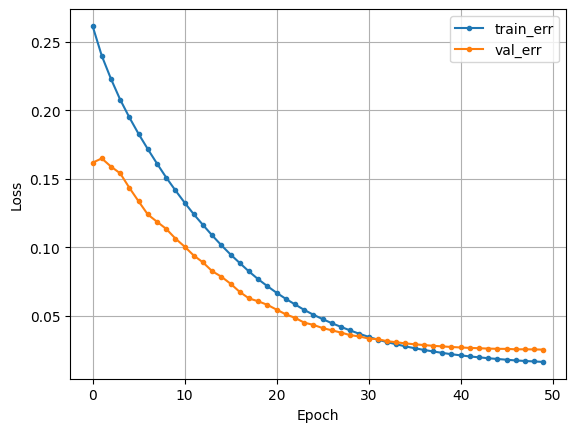

In [78]:
dl_history_plot(history)

2/2 [==============================] - 0s 3ms/step


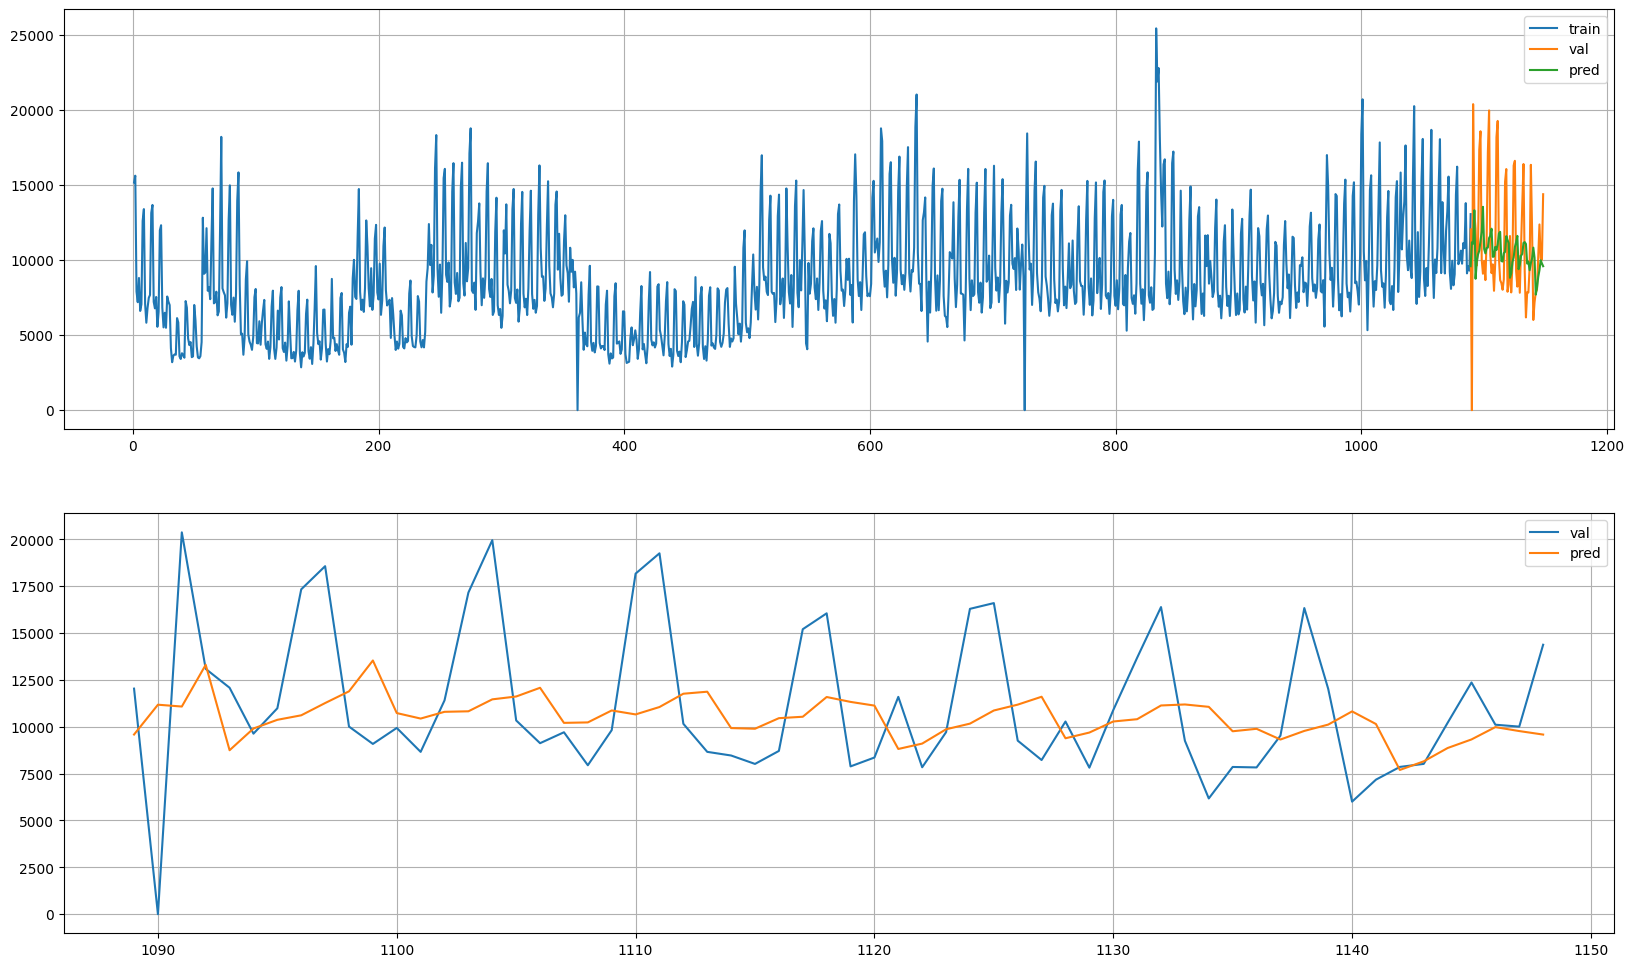

In [79]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [80]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 4034.22
MAE : 3084.48
MAPE: 8.388086980380635e+17
R2  : -0.03


# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [81]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

### 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

In [82]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [83]:
def data_split2(df, target, val_size, timesteps):
    # X, y 분할
    X = df.drop([target, 'Date'], axis=1)
    y = df.loc[:, target]

    # 3차원 구조로 만들기
    X2, y2 = temporalize(X, y, timesteps)

    # 데이터 분할
    X_train, X_valid, y_train, y_valid = train_test_split(X2, y2, test_size=val_size, shuffle=False, random_state=42)

    # 2차원으로 변환하여 스케일러 생성
    scaler = MinMaxScaler().fit(flatten(X_train))

    # 3차원 데이터에 스테일러 적용
    X_train_s = scale(X_train, scaler)
    X_valid_s = scale(X_valid, scaler)

    # y에 대한 스케일링(최적화를 위해)
    scaler_y = MinMaxScaler()
    y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))
    y_valid_s = scaler_y.transform(y_valid.reshape(-1,1))

    return X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y

In [84]:
def LSTM_model_training(nfeatures, epochs, timesteps):
    clear_session()

    model = Sequential([LSTM(32, input_shape=(timesteps, nfeatures)),
                        Dense(1)])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    history = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=epochs).history

    return history, model

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [85]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split2(df_3, target, val_size, timesteps)

In [86]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 6), (60, 7, 6), (1083, 1), (60, 1))

In [87]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = LSTM_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
34/34 [==============================] - 2s 16ms/step - loss: 0.0234 - val_loss: 0.0272
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0233
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0125 - val_loss: 0.0217
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0181
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0078 - val_loss: 0.0174
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0154
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0190
Epoch 8/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0056 - val_loss: 0.0155
Epoch 9/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0157
Epoch 10/50
34/34 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0150
Epoch 11/50
34/34 

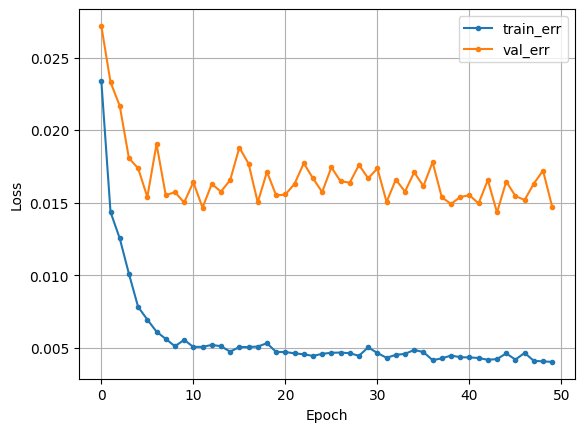

In [88]:
dl_history_plot(history)

2/2 [==============================] - 0s 4ms/step


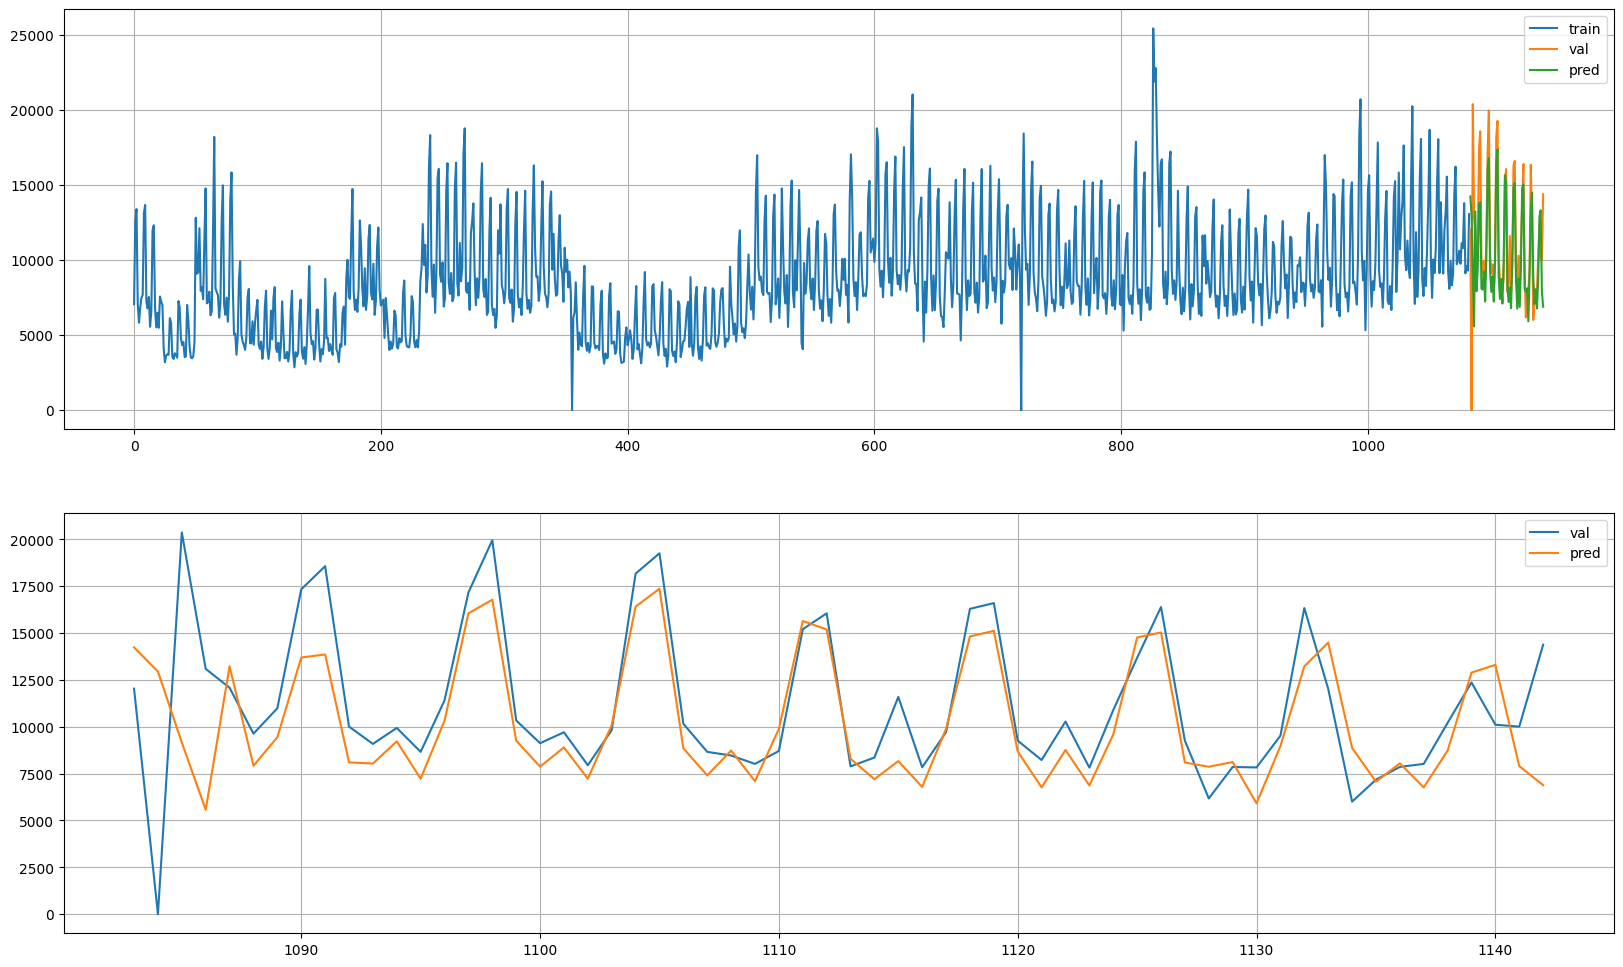

In [89]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [90]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 3081.72
MAE : 1981.55
MAPE: 9.717478635230025e+17
R2  : 0.4


## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [92]:
def CNN_model_training(nfeatures, epochs, timesteps):
    clear_session()

    model = Sequential([Conv1D(32, 7, input_shape=(timesteps, nfeatures), activation='relu', padding='same'),
                        Flatten(),
                        Dense(1)])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

    history = model.fit(X_train_s, y_train_s, validation_data=(X_valid_s, y_valid_s), epochs=epochs).history

    return history, model

In [93]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 6), (60, 7, 6), (1083, 1), (60, 1))

In [94]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = CNN_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
34/34 [==============================] - 2s 9ms/step - loss: 0.0317 - val_loss: 0.0262
Epoch 2/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0188
Epoch 3/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0180
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0178
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0162
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0218
Epoch 7/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0166
Epoch 8/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0151
Epoch 9/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0181
Epoch 10/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0154
Epoch 11/50
34/34 [

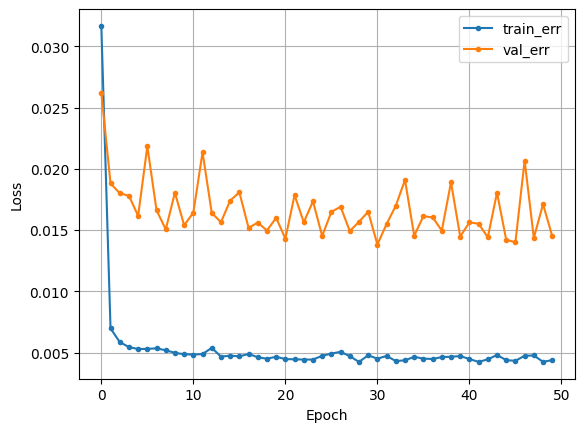

In [95]:
dl_history_plot(history)

2/2 [==============================] - 0s 3ms/step


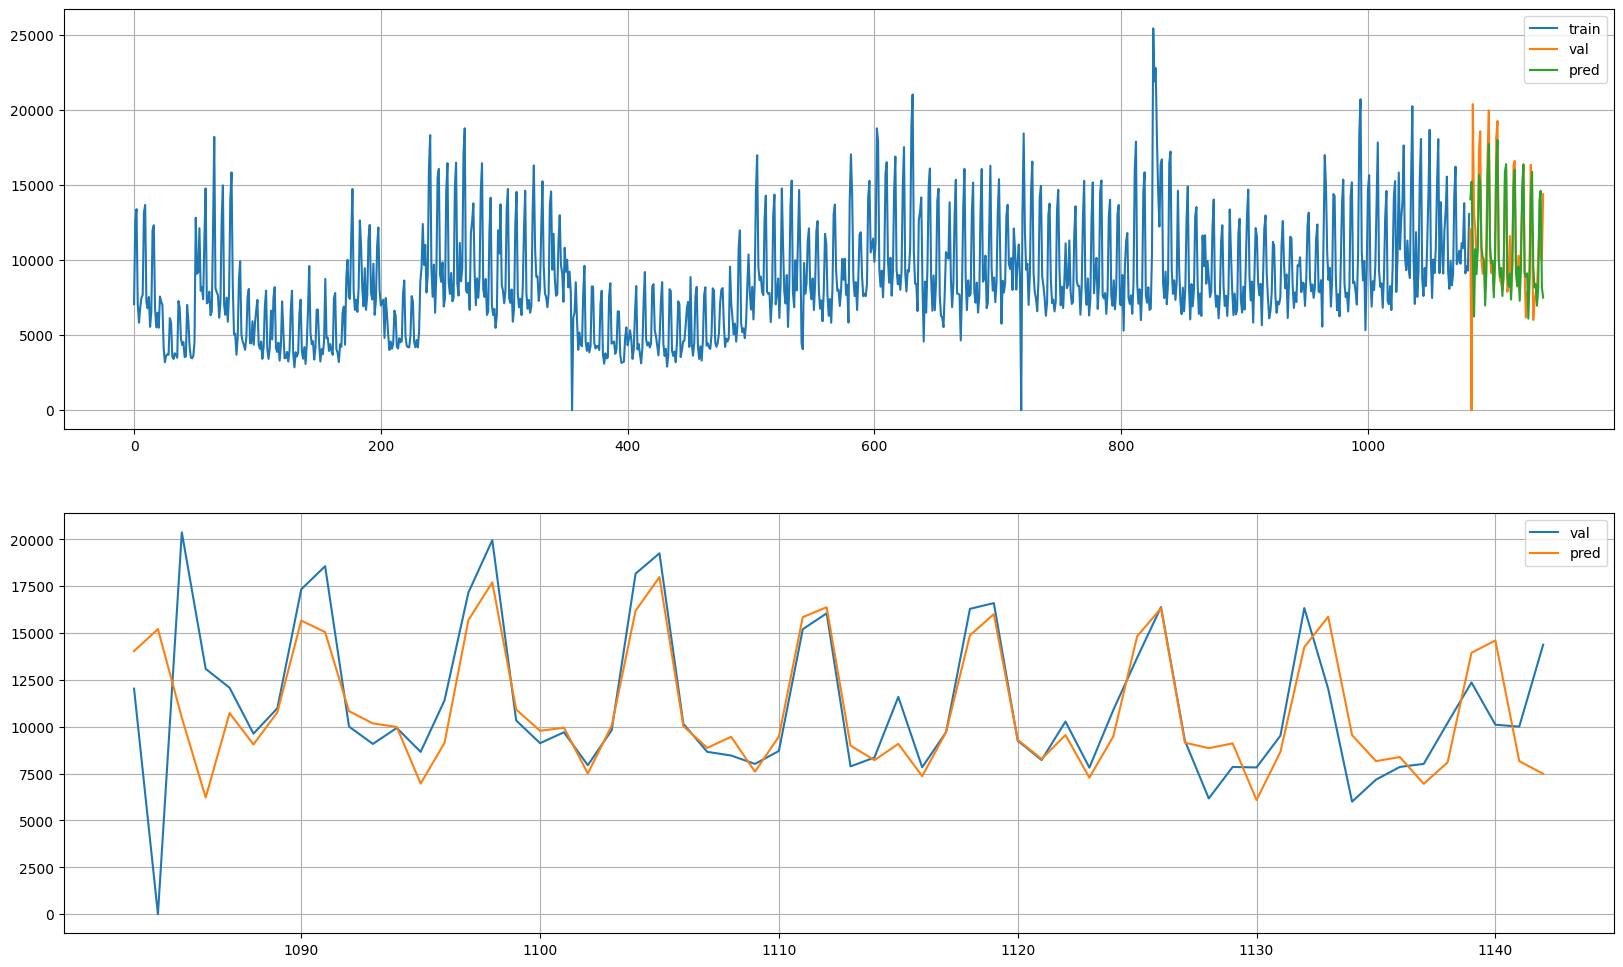

In [96]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [97]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 3061.21
MAE : 1760.91
MAPE: 1.1414839448500699e+18
R2  : 0.41


# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [100]:
import joblib

# 주어진 경로에 저장하기
joblib.dump(df_3, path + 'df_3.pkl')

['/content/drive/MyDrive/project/df_3.pkl']